## Importing Libraries

In [9]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier  # XGBoost
from sklearn.multiclass import OneVsRestClassifier
from lazypredict.Supervised import LazyClassifier

import joblib

## 1. Loading Dataset


In [24]:
# loading the dataset
data = pd.read_csv('../Dataset/StudentPlacement.csv')
data.tail()

,DSA,DBMS,OS,CN,Mathmetics,Aptitute,Comm,Problem Solving,Creative,Hackathons,Skill 1,Skill 2,Profile
803,47,78,77,48,44,30,60,4,7,7,Node.js,Angular,Web Developer
804,64,91,73,74,45,47,82,7,7,3,C/C++,Linux,Database Administrator
805,96,78,81,85,78,98,70,8,6,5,Python,MySQL,Software Engineer
806,31,77,62,67,85,67,67,7,6,3,PyTorch,Machine Learning,DATA Scientist
807,51,50,32,40,34,23,79,2,10,5,GitHub,Photoshop,UI/UX


In [26]:
data.shape

(808, 13)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DSA              808 non-null    int64 
 1   DBMS             808 non-null    int64 
 2   OS               808 non-null    int64 
 3   CN               808 non-null    int64 
 4   Mathmetics       808 non-null    int64 
 5   Aptitute         808 non-null    int64 
 6   Comm             808 non-null    int64 
 7   Problem Solving  808 non-null    int64 
 8   Creative         808 non-null    int64 
 9   Hackathons       808 non-null    int64 
 10  Skill 1          808 non-null    object
 11  Skill 2          808 non-null    object
 12  Profile          808 non-null    object
dtypes: int64(10), object(3)
memory usage: 82.2+ KB


In [32]:
data.isnull().sum()

DSA                0
DBMS               0
OS                 0
CN                 0
Mathmetics         0
Aptitute           0
Comm               0
Problem Solving    0
Creative           0
Hackathons         0
Skill 1            0
Skill 2            0
Profile            0
dtype: int64

In [34]:
data[data.duplicated(data.columns[:-1])]

,DSA,DBMS,OS,CN,Mathmetics,Aptitute,Comm,Problem Solving,Creative,Hackathons,Skill 1,Skill 2,Profile


- We can see that there are 0 duplicated values in the dataset

In [39]:
data["Profile"].unique()

array(['Web Developer', 'UI/UX', 'Network Engineer', 'DATA Scientist',
       'Tech Support', 'Database Administrator', 'Software Engineer'],
      dtype=object)

- This dataset contains the following profiles as target varibale 'UI/UX', 'Web Developer', 'DATA Scientist', 'Software Engineer', 'Database Administrator', 'Network Engineer', 'Tech Support'

In [44]:
# Extracting the numerical and categorical features
numerical_data = data.select_dtypes(include=['number'])
categorical_data = data.select_dtypes(include=['object', 'category'])

In [46]:
# getting the numerical and categorical columns
numerical_cols = numerical_data.columns
categorical_cols = categorical_data.columns

In [48]:
# no of unique values does each numberical feature haves
numerical_data.nunique() 

DSA                94
DBMS               95
OS                 91
CN                 96
Mathmetics         99
Aptitute           87
Comm               51
Problem Solving    10
Creative            9
Hackathons         11
dtype: int64

# 2. EDA

## 2.1. EDA on Numerical Data
### 2.1.1. Understanding the co-relations

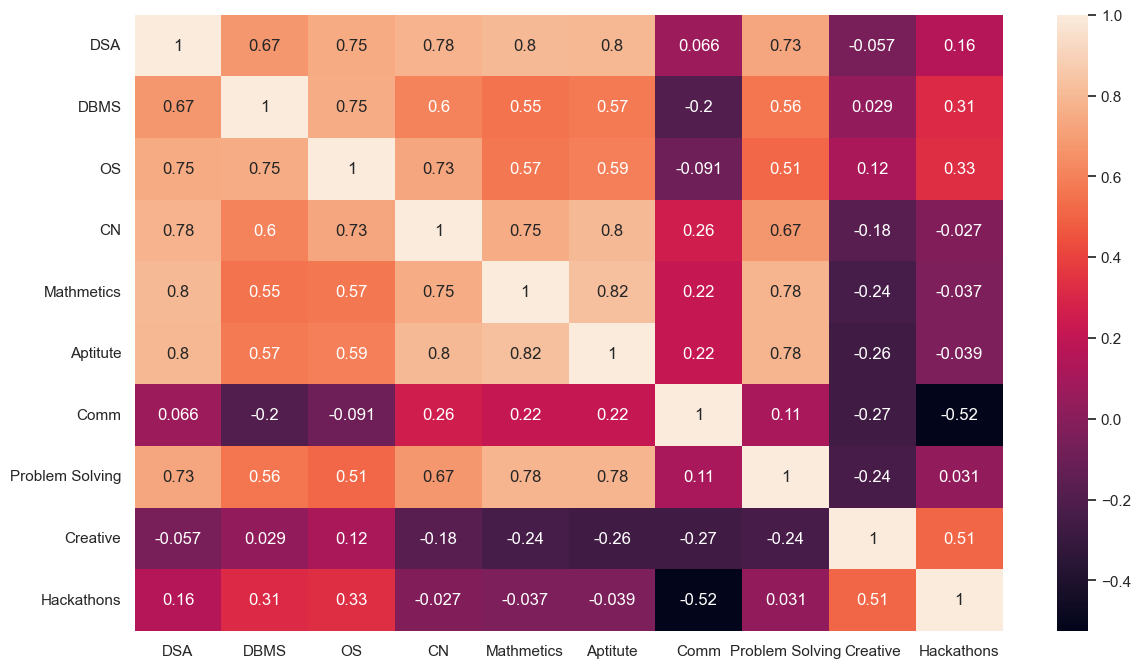

In [67]:
# Set the figure size
sns.set(rc={'figure.figsize':(14, 8)})  # width=10, height=6

sns.heatmap(numerical_data.corr(), annot = True)
plt.show()

### 2.1.2. Distribution of the numerical feature

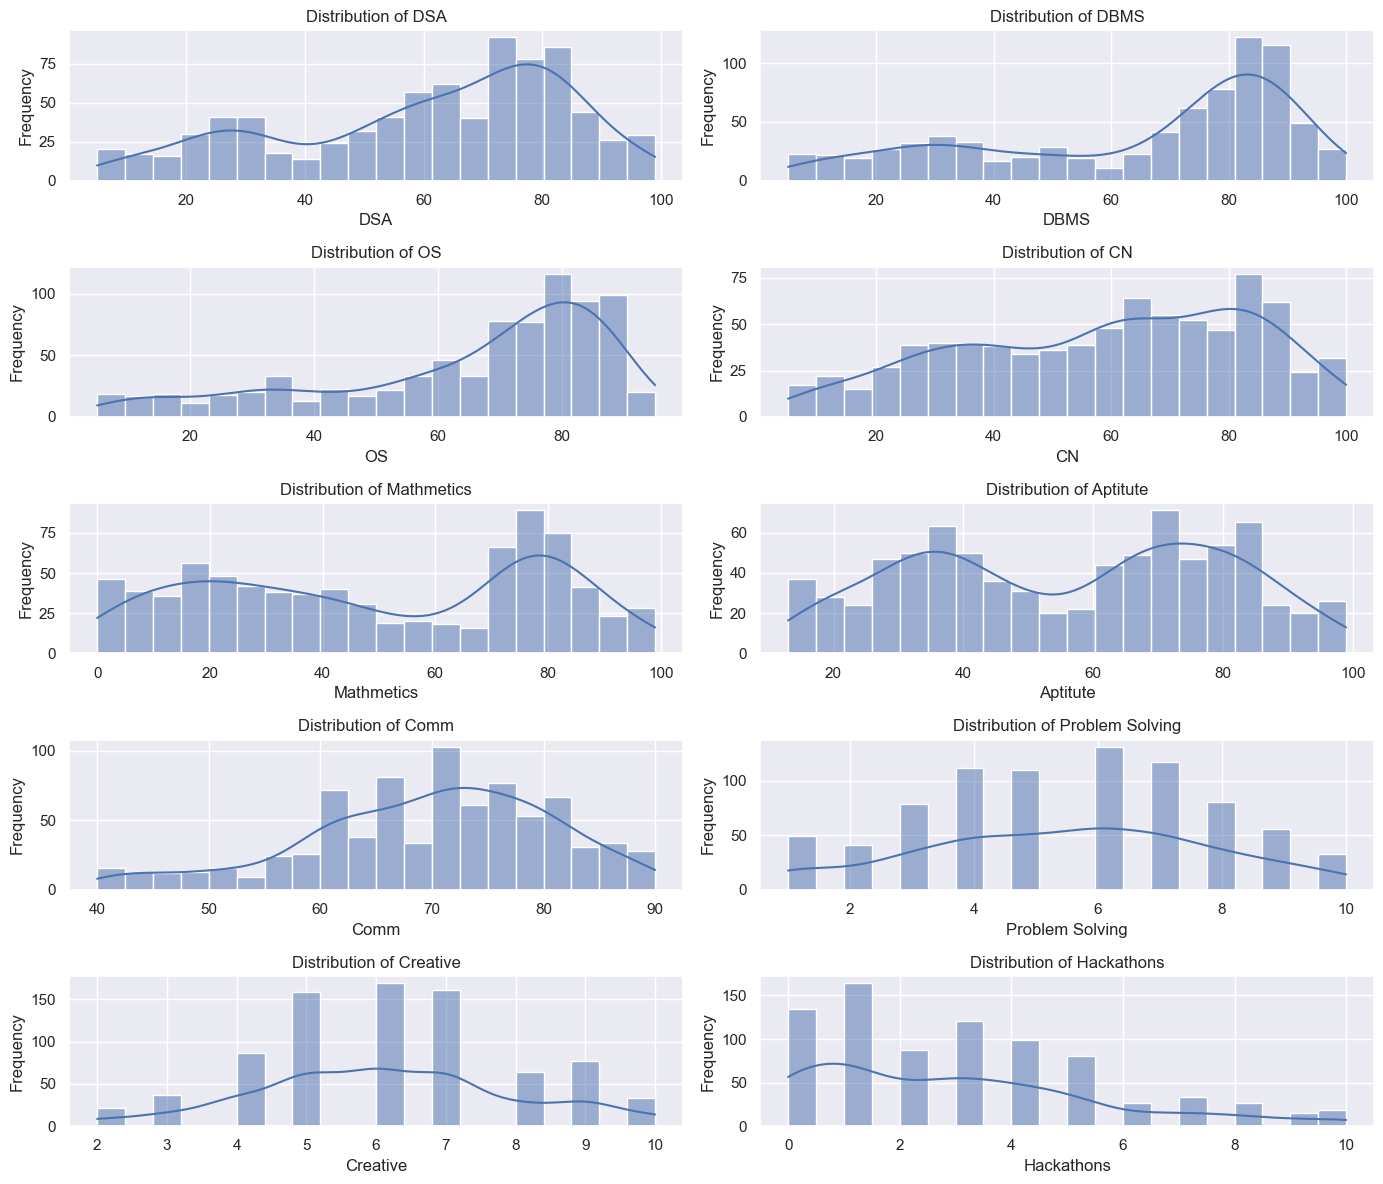

In [71]:
# Set plot size
plt.figure(figsize=(14, 12))

# Loop through each numerical column and plot the distribution
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(5, 2, i)
    sns.histplot(data[col], kde=True, bins=20)  # Histogram with kernel density estimate (KDE)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### 2.1.3. Box Plot Visualization

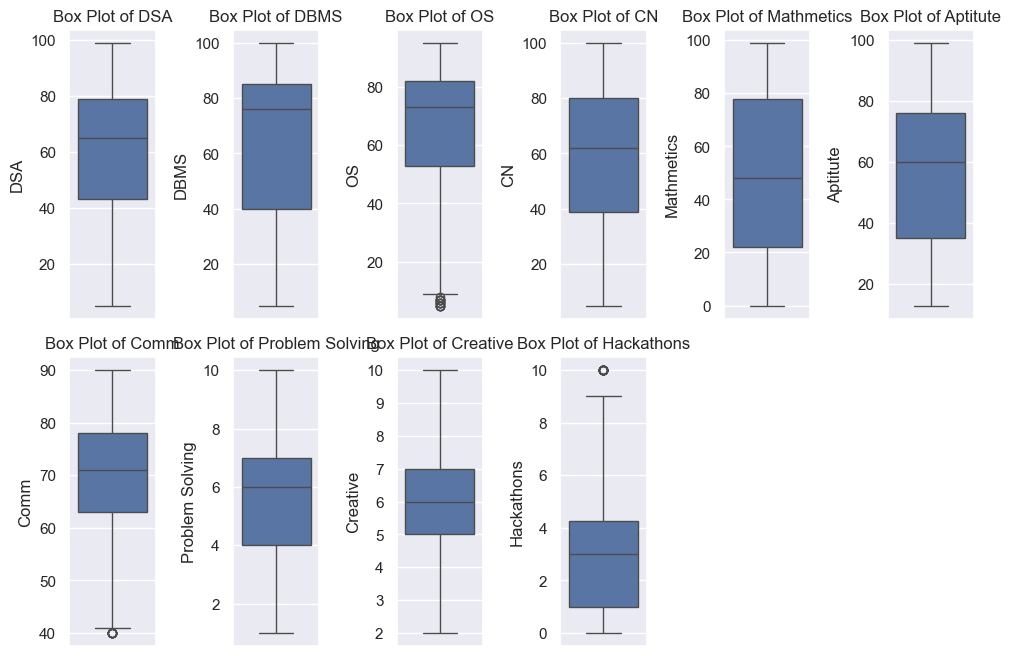

In [73]:
# Set plot size
plt.figure(figsize=(10, 10))

# Loop through each numerical column and plot a box plot
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 6, i)
    sns.boxplot(y=data[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

### 2.1.3.1. Removing Outliers Using IQR

In [77]:
# Function to remove outliers based on IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# Remove outliers from the numerical columns
cleaned_data = remove_outliers(data.copy(), numerical_cols)

### 2.1.4. Percentage of profile job roles
- Checking the percentage of jobs that we have in the dataset

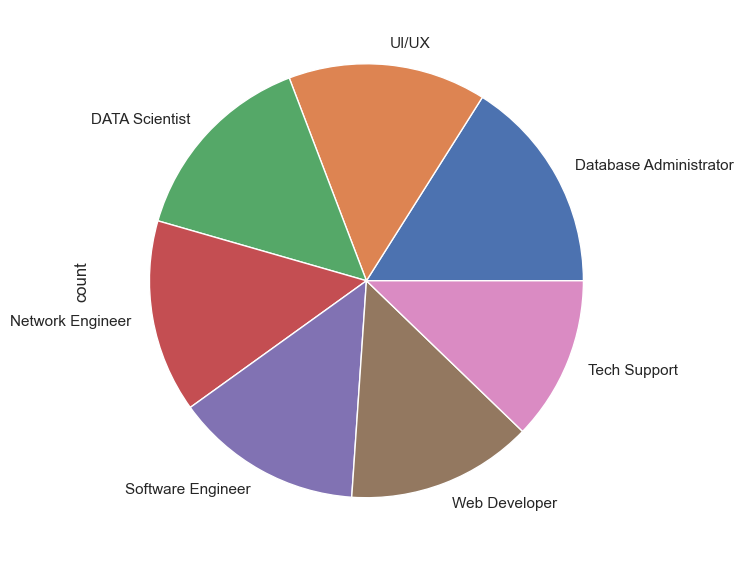

In [87]:
# Set plot size
plt.figure(figsize=(7, 10))

cleaned_data['Profile'].value_counts().plot.pie()
plt.show()

- We can see from the pie chart that mostly all of them have same percentage of distribution in the dataset
## 3. Data Preprocessing
### 3.1. Skills Column encoding
- We can see that Skill 1 and Skill 2 column have categorical values and needed to encode them

In [90]:
# Seeing weather the skill 1 and skill 2 column have same unique skills or not
skill1_values = sorted(cleaned_data["Skill 1"].unique())
skill2_values = sorted(cleaned_data['Skill 2'].unique())

print(skill1_values == skill2_values)

True


In [92]:
skill1_values

['Angular',
 'Ansible',
 'BASH/SHELL',
 'C/C++',
 'Cisco Packet Tracer',
 'Deep Learning',
 'Figma',
 'GitHub',
 'HTML/CSS',
 'Java',
 'JavaScript',
 'Linux',
 'Machine Learning',
 'MySQL',
 'Node.js',
 'Oracle',
 'Photoshop',
 'PyTorch',
 'Python',
 'R',
 'React',
 'TensorFlow',
 'Wireshark']

- "True" indicates that the column skill 1 and skill 2 of the dataset have same values, so we can use the same labelEncoder for the columns to encode and we can use the same for the decoder of the skills columns
- To perform one-hot encoding on the columns Skill 1 and Skill 2, and ensure that they have higher importance compared to the other features

In [95]:
# Step 1: One-hot encode 'Skill 1' and 'Skill 2'
skill_encoder = OneHotEncoder( handle_unknown='ignore')

In [97]:
# Step 2: Fit the encoder on 'Skill 1' and 'Skill 2' columns
skills_encoded = skill_encoder.fit_transform(cleaned_data[['Skill 1', 'Skill 2']]).toarray() * 2.0
skills_encoded 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [99]:
# getting all column names
skill_encoder.get_feature_names_out(['Skill 1', 'Skill 2'])

array(['Skill 1_Angular', 'Skill 1_Ansible', 'Skill 1_BASH/SHELL',
       'Skill 1_C/C++', 'Skill 1_Cisco Packet Tracer',
       'Skill 1_Deep Learning', 'Skill 1_Figma', 'Skill 1_GitHub',
       'Skill 1_HTML/CSS', 'Skill 1_Java', 'Skill 1_JavaScript',
       'Skill 1_Linux', 'Skill 1_Machine Learning', 'Skill 1_MySQL',
       'Skill 1_Node.js', 'Skill 1_Oracle', 'Skill 1_Photoshop',
       'Skill 1_PyTorch', 'Skill 1_Python', 'Skill 1_R', 'Skill 1_React',
       'Skill 1_TensorFlow', 'Skill 1_Wireshark', 'Skill 2_Angular',
       'Skill 2_Ansible', 'Skill 2_BASH/SHELL', 'Skill 2_C/C++',
       'Skill 2_Cisco Packet Tracer', 'Skill 2_Deep Learning',
       'Skill 2_Figma', 'Skill 2_GitHub', 'Skill 2_HTML/CSS',
       'Skill 2_Java', 'Skill 2_JavaScript', 'Skill 2_Linux',
       'Skill 2_Machine Learning', 'Skill 2_MySQL', 'Skill 2_Node.js',
       'Skill 2_Oracle', 'Skill 2_Photoshop', 'Skill 2_PyTorch',
       'Skill 2_Python', 'Skill 2_R', 'Skill 2_React',
       'Skill 2_TensorFlow

In [101]:
# Create a DataFrame from the dense array
skills_encoded_df = pd.DataFrame(skills_encoded, columns=skill_encoder.get_feature_names_out(['Skill 1', 'Skill 2']))
skills_encoded_df

,Skill 1_Angular,Skill 1_Ansible,Skill 1_BASH/SHELL,Skill 1_C/C++,Skill 1_Cisco Packet Tracer,Skill 1_Deep Learning,Skill 1_Figma,Skill 1_GitHub,Skill 1_HTML/CSS,Skill 1_Java,...,Skill 2_MySQL,Skill 2_Node.js,Skill 2_Oracle,Skill 2_Photoshop,Skill 2_PyTorch,Skill 2_Python,Skill 2_R,Skill 2_React,Skill 2_TensorFlow,Skill 2_Wireshark
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,...,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
782,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
783,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
784,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [103]:
numerical_features = cleaned_data.drop(columns=['Skill 1', 'Skill 2', 'Profile'])

In [105]:
# Step 2: Combine original numerical features with encoded skill columns
X = pd.concat([numerical_features.reset_index(drop=True), skills_encoded_df.reset_index(drop=True)], axis=1)

In [107]:
# Step 3: Adjust feature importance by scaling and assigning higher weight to skills
scaler = StandardScaler()
X[X.columns[:10]] = scaler.fit_transform(X[X.columns[:10]])

In [109]:
X

,DSA,DBMS,OS,CN,Mathmetics,Aptitute,Comm,Problem Solving,Creative,Hackathons,...,Skill 2_MySQL,Skill 2_Node.js,Skill 2_Oracle,Skill 2_Photoshop,Skill 2_PyTorch,Skill 2_Python,Skill 2_R,Skill 2_React,Skill 2_TensorFlow,Skill 2_Wireshark
0,0.25,0.66,0.53,-0.80,-1.06,-0.71,-2.02,0.20,1.53,2.34,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,-1.64,-0.74,1.08,0.64,-1.43,-0.88,-1.47,-1.51,0.99,-0.01,...,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00
2,-1.13,-0.74,-1.20,-0.43,-0.89,-0.88,-0.73,-0.66,0.99,0.38,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.51,-0.71,0.71,1.21,0.73,0.95,0.75,0.20,-0.09,-0.79,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
4,-1.22,-1.62,-0.65,-0.84,-0.93,-1.69,1.03,-0.66,2.07,0.77,...,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,-0.59,0.51,0.53,-0.47,-0.22,-1.14,-0.91,-0.66,0.45,1.55,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
782,0.13,1.00,0.35,0.60,-0.18,-0.42,1.12,0.62,0.45,-0.01,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
783,1.48,0.51,0.71,1.05,0.93,1.76,0.01,1.05,-0.09,0.77,...,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
784,-1.26,0.47,-0.15,0.31,1.17,0.44,-0.27,0.62,-0.09,-0.01,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### 3.2. Profile Column encoding
- Profile feature is our target variable and needed to encode in order make it trainable ready

In [112]:
profile_encoder = LabelEncoder()
cleaned_data['Profile'] = profile_encoder.fit_transform(cleaned_data['Profile'])

# Target column (Profile)
y = cleaned_data['Profile']

### 3.3. Train Test Split

In [117]:
# making sure that the shape of X and y are same
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (786, 56)
Shape of y: (786,)


In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.3, stratify=y)

# 4. Model Training
### Explanation:
This function, optimize_tree_and_boosting_models, performs hyperparameter tuning for four machine learning models: Decision Tree (DT), Random Forest (RF), Gradient Boosting (GB), and XGBoost (XGB). Here's how it works:

1. **Hyperparameter Space Definition:**

- Each model is assigned a set of hyperparameters to search over, such as max_depth, min_samples_split, learning_rate, etc.
Model Initialization:

2. **Model Initialization:**

The four models (DT, RF, GB, and XGB) are initialized with random_state=42 for reproducibility. The XGBClassifier has the eval_metric set to 'mlogloss'.
Grid Search with Cross-Validation:

3. **Grid Search with Cross-Validation:**

The function uses GridSearchCV to perform an exhaustive search over the specified hyperparameter space for each model.
It uses 5-fold cross-validation (cv=5) and parallel computation (n_jobs=-1).

4. **Fitting Models:**

The models are fitted to the training data (X_train and y_train), and the best combination of hyperparameters is selected.

5. **Results:**

The best parameters and scores for each model are printed.
The best models for each algorithm are stored in best_models.

### In short:
The function automatically finds the best hyperparameters for DT, RF, GB, and XGB models using grid search with cross-validation, and stores the optimized models for further use.

## 4.1. GridSearchCV

In [126]:
def optimize_tree_and_boosting_models(X_train, y_train):
    # Define hyperparameter space for each model
    param_spaces = {
        'DT': {
            'max_depth': [5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 3, 5],
        },
        'RF': {
            'n_estimators': [200, 250, 300],
            'max_depth': [10, 15, 20],
            'min_samples_split': [1, 2, 5],
            'min_samples_leaf': [1, 2, 5],
            'bootstrap': [True, False],
        },
        
        'GB': {  # Gradient Boosting
            'n_estimators': [10, 50, 100],
            'learning_rate': [0.01, 0.1, 0.5],
            'max_depth': [10, 15, 20],
            'subsample': [0.1, 0.3, 0.8],
        },
        'XGB': {  # XGBoost
            'n_estimators': [300, 400, 500],
            'learning_rate': [0.001, 0.01, 0.1],
            'max_depth': [3, 5, 10],
            'subsample': [0.5, 0.8, 1.0],
            'colsample_bytree': [0.01, 0.1, 0.5],
        }
    }

    # Initialize the models
    models = {
        'DT': DecisionTreeClassifier(random_state=42),
        'RF': RandomForestClassifier(random_state=42),
        'GB': GradientBoostingClassifier(random_state=42),
        'XGB': XGBClassifier(random_state=42, eval_metric='mlogloss'),  # Removed use_label_encoder
    }

    best_models = {}

    # Loop through models and optimize each using GridSearchCV
    for model_name in models:
        print(f"Optimizing {model_name}...")
        
        # Initialize GridSearchCV
        opt = GridSearchCV(
            models[model_name],
            param_spaces[model_name],
            cv=5,  # 5-fold cross-validation
            n_jobs=-1,  # Use all available cores
            verbose=0
        )
        
        # Fit the GridSearchCV on the training data
        opt.fit(X_train, y_train)
        
        # Store the best model found
        best_models[model_name] = opt.best_estimator_
        print(f"Best parameters for {model_name}: {opt.best_params_}")
        print(f"Best score for {model_name}: {opt.best_score_}\n")
    
    return best_models


# Optimize and get the best models
best_models = optimize_tree_and_boosting_models(X_train, y_train)

Optimizing DT...
Best parameters for DT: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best score for DT: 0.9381818181818181

Optimizing RF...
Best parameters for RF: {'bootstrap': False, 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}
Best score for RF: 0.9672727272727274

Optimizing GB...
Best parameters for GB: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.3}
Best score for GB: 0.9709090909090909

Optimizing XGB...
Best parameters for XGB: {'colsample_bytree': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.8}
Best score for XGB: 0.9800000000000001



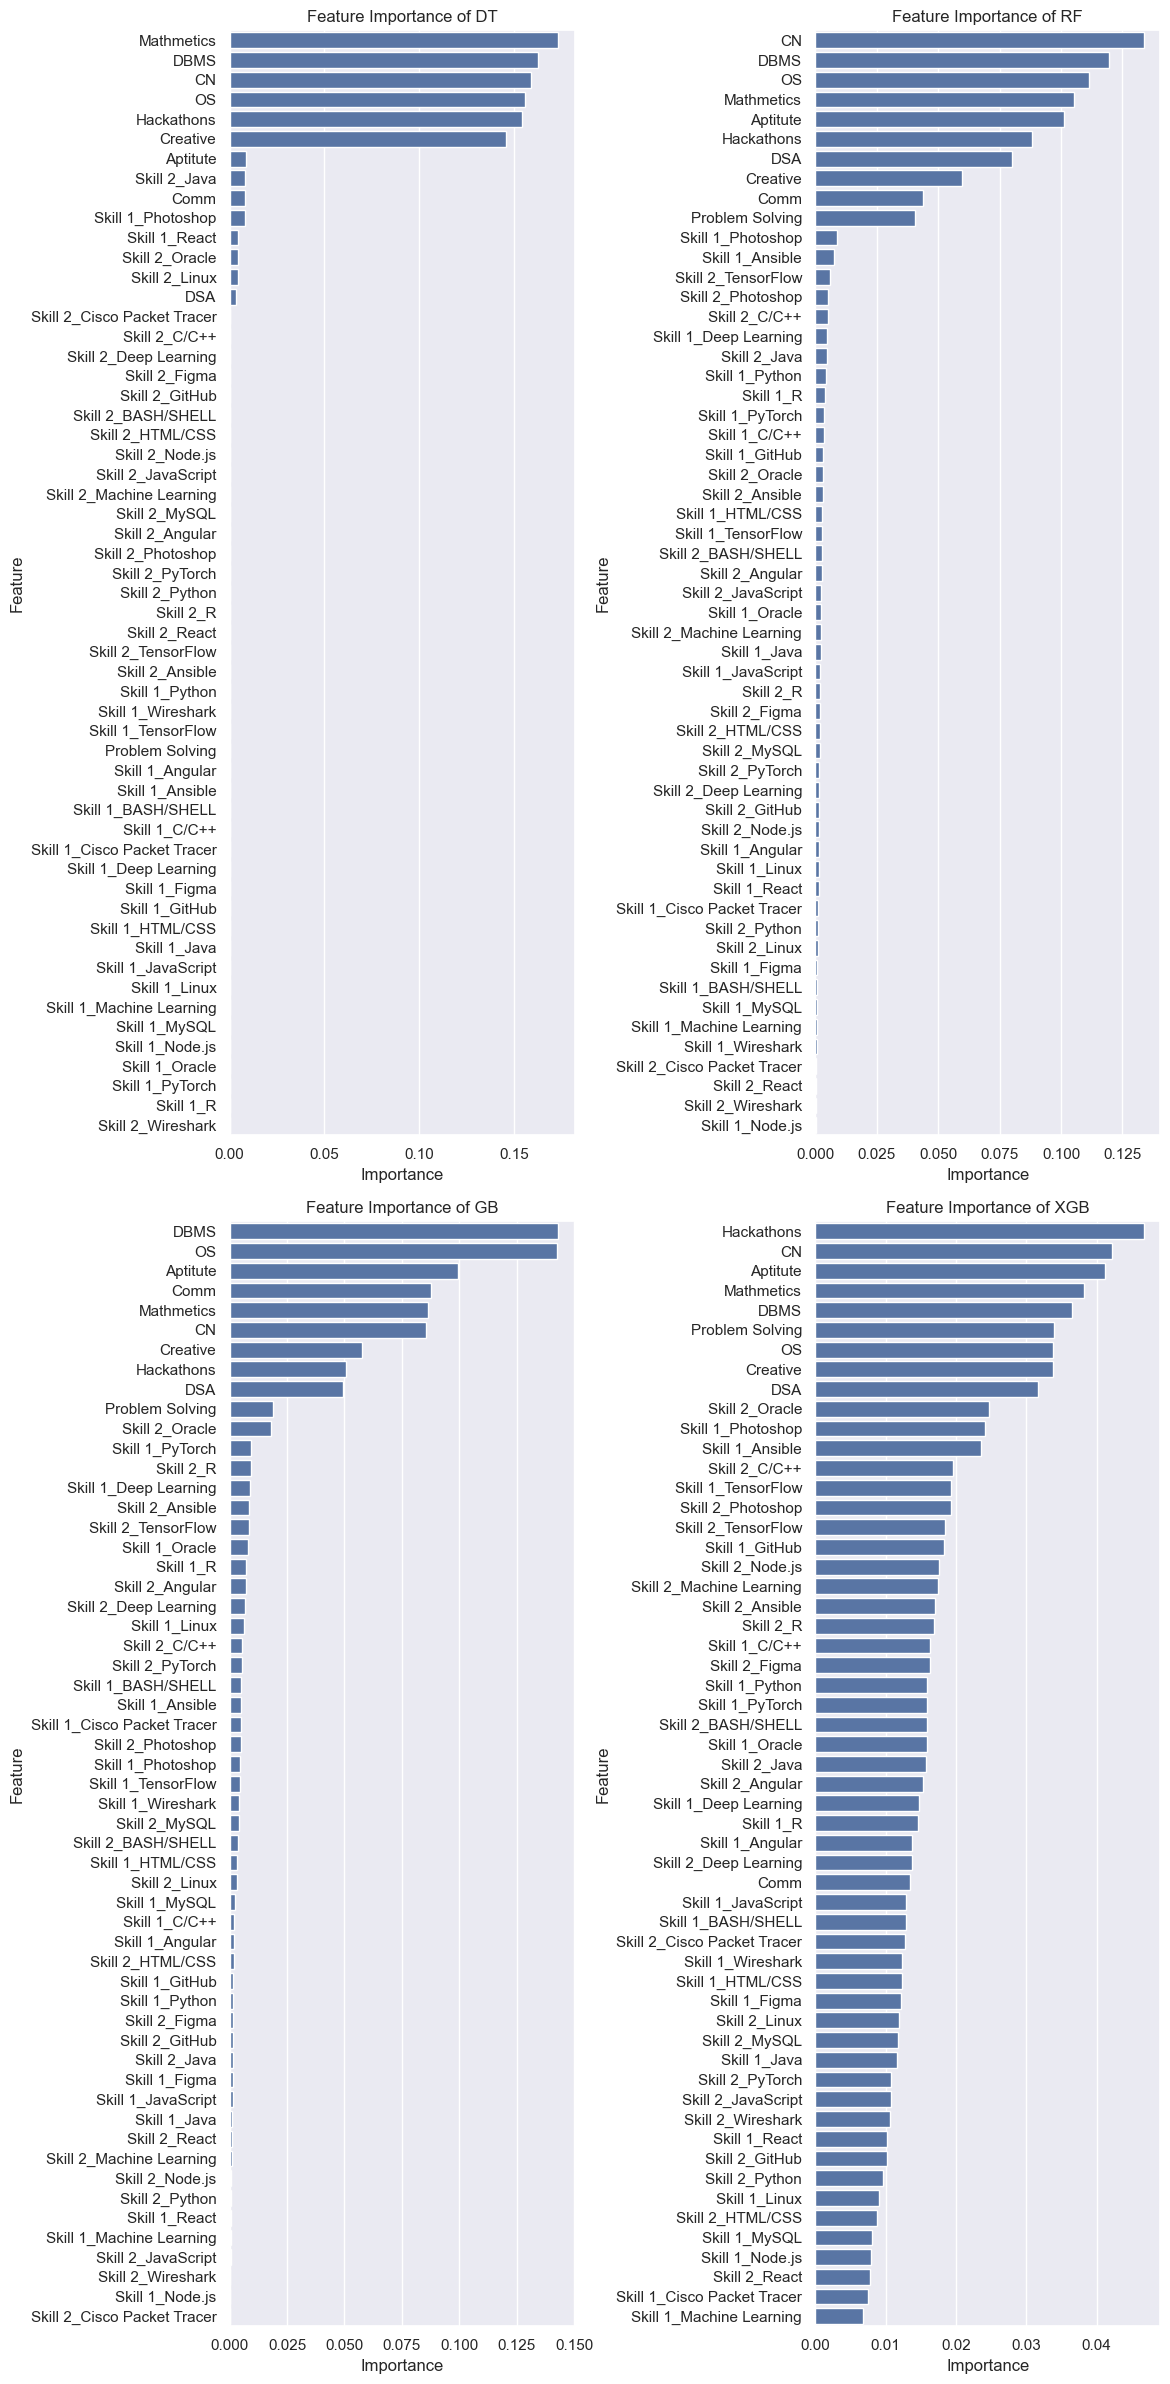

In [128]:
# Plots feature importance for models that have 'feature_importances_' attribute in a grid layout.
def plot_feature_importance(X, best_models):
   
    models_with_importance = [model_name for model_name, model in best_models.items() if hasattr(model, 'feature_importances_')]
    num_models = len(models_with_importance)
    nrows = (num_models + 1) // 2  # Ensures proper row count for even/odd models
    ncols = 2  # 2 columns for the grid layout
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12 * nrows))
    axes = axes.flatten()  # Flatten axes in case there's only one row or column
    
    for idx, model_name in enumerate(models_with_importance):
        model = best_models[model_name]
        importance = model.feature_importances_
        imp_df = pd.DataFrame({"Feature": X.columns, "Importance": importance})
        imp_df = imp_df.sort_values(by="Importance", ascending=False)
        
        sns.barplot(x=imp_df['Importance'], y=imp_df['Feature'], ax=axes[idx])
        axes[idx].set_title(f"Feature Importance of {model_name}")
    
    # If there are empty subplots (when number of models < total subplots), turn off those axes
    for i in range(len(models_with_importance), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# plotting the graph for feature importance
plot_feature_importance(X_train, best_models)

## 4.2. Learning Curve
## Step-by-Step Instructions:
1. **Use learning_curve:**

- The function takes a model, the dataset, and parameters like the cross-validation strategy and scoring metric.
- It will return the training and validation scores across different training sizes.

2. **Plot the learning curve:**

- You can use matplotlib to plot the learning curve, which will show the training score and validation score as a function of the number of training samples.
### Key Components:
1. **learning_curve Function:**

- **estimator:** The model for which you want to generate the learning curve.
- **X_train, y_train:** Your training data.
- **cv:** Cross-validation strategy (default 5-fold).
- **scoring:** The evaluation metric (e.g., accuracy, f1, precision, etc.).
- **train_sizes:** A sequence of values that defines the proportions of the training set to use (here it's between 10% and 100%).

2. **Plotting:**

- The training and validation (cross-validation) scores are plotted with a confidence interval (standard deviation).

3. **Example Usage:**

- The function plot_learning_curve is called for each model stored in best_models after Bayesian Optimization.
### Output:
Training Score: Shows how well the model fits the training data as the size of the training set increases.

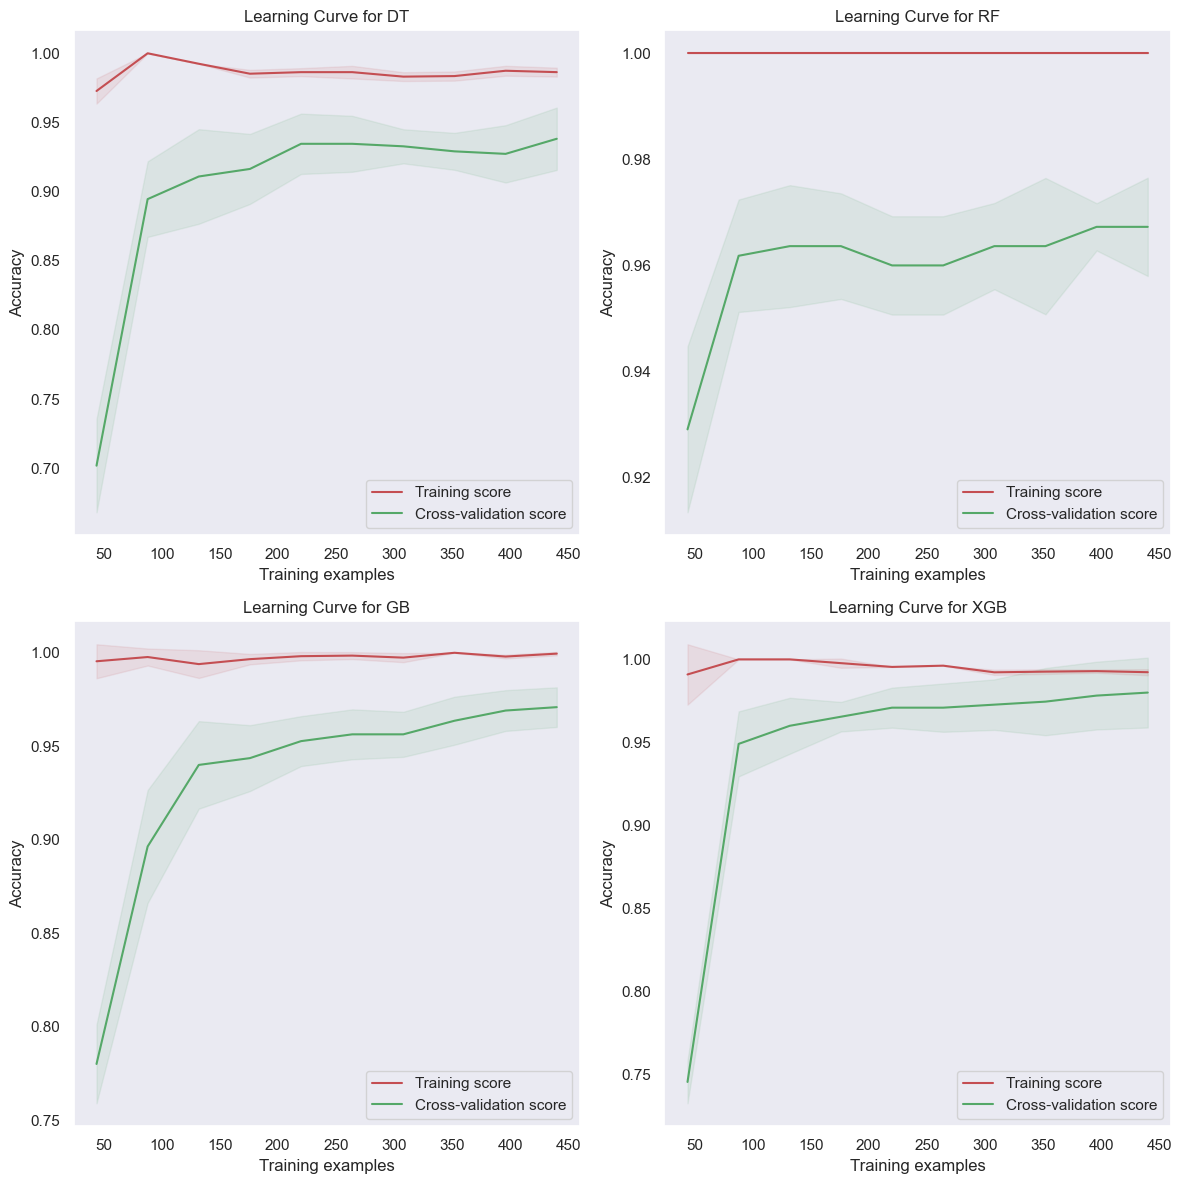

In [133]:
"""Plots learning curves for all models in a 2x2 grid."""
def plot_learning_curves(best_models, X_train, y_train, cv=5, scoring='accuracy'):
    
    num_models = len(best_models)
    nrows = (num_models + 1) // 2  # Dynamically calculate rows
    ncols = 2  # Set columns to 2 for the grid layout
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6 * nrows))
    axes = axes.flatten()  # Flatten the grid to easily iterate over subplots
    
    for idx, (model_name, model) in enumerate(best_models.items()):
        # Generate learning curve data
        train_sizes, train_scores, test_scores = learning_curve(
            model, X_train, y_train, cv=cv, n_jobs=-1, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10)
        )
        
        # Calculate mean and standard deviation for training and validation scores
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot learning curve
        ax = axes[idx]  # Select subplot
        ax.set_title(f"Learning Curve for {model_name}")
        ax.set_xlabel("Training examples")
        ax.set_ylabel(scoring.capitalize())
        
        # Plot the training score curve
        ax.plot(train_sizes, train_scores_mean, label="Training score", color="r")
        ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, color="r", alpha=0.1)
        
        # Plot the validation score curve
        ax.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="g")
        ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, color="g", alpha=0.1)
        
        ax.legend(loc="best")
        ax.grid()

    # If there are fewer models than subplots, turn off extra axes
    for i in range(len(best_models), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


# Plot learning curves for all models
plot_learning_curves(best_models, X_train, y_train)

### 4.3. Confusion Matrix

In [136]:
# Model evaluations
def evaluate_models_on_test(best_models, X_test, y_test):
    """Evaluates each model in the best_models dictionary on the test dataset and prints the test score."""
    
    test_scores = {}
    
    # Loop through each model and compute its test score
    for model_name, model in best_models.items():
        # Get predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate the accuracy score (or you can use another metric like f1_score, precision, etc.)
        score = accuracy_score(y_test, y_pred)
        
        # Store the score in the dictionary
        test_scores[model_name] = score

        print(f"Classification Report of {model_name}: \n\n{classification_report(y_test, y_pred)}\n")
        
        # Print the test score for the model
        print(f"{model_name} Test Accuracy: {score:.2f}\n\n")
    
    return test_scores


# testing the data on best trained models 
test_scores = evaluate_models_on_test(best_models, X_test, y_test)

Classification Report of DT: 

              precision    recall  f1-score   support

           0       0.89      0.94      0.92        35
           1       0.91      0.84      0.88        38
           2       0.89      0.94      0.91        34
           3       0.94      0.91      0.92        33
           4       0.97      0.97      0.97        29
           5       0.97      1.00      0.99        35
           6       0.97      0.94      0.95        32

    accuracy                           0.93       236
   macro avg       0.93      0.93      0.93       236
weighted avg       0.93      0.93      0.93       236


DT Test Accuracy: 0.93


Classification Report of RF: 

              precision    recall  f1-score   support

           0       0.92      0.97      0.94        35
           1       0.95      0.95      0.95        38
           2       1.00      1.00      1.00        34
           3       1.00      0.94      0.97        33
           4       0.97      1.00      0.98 

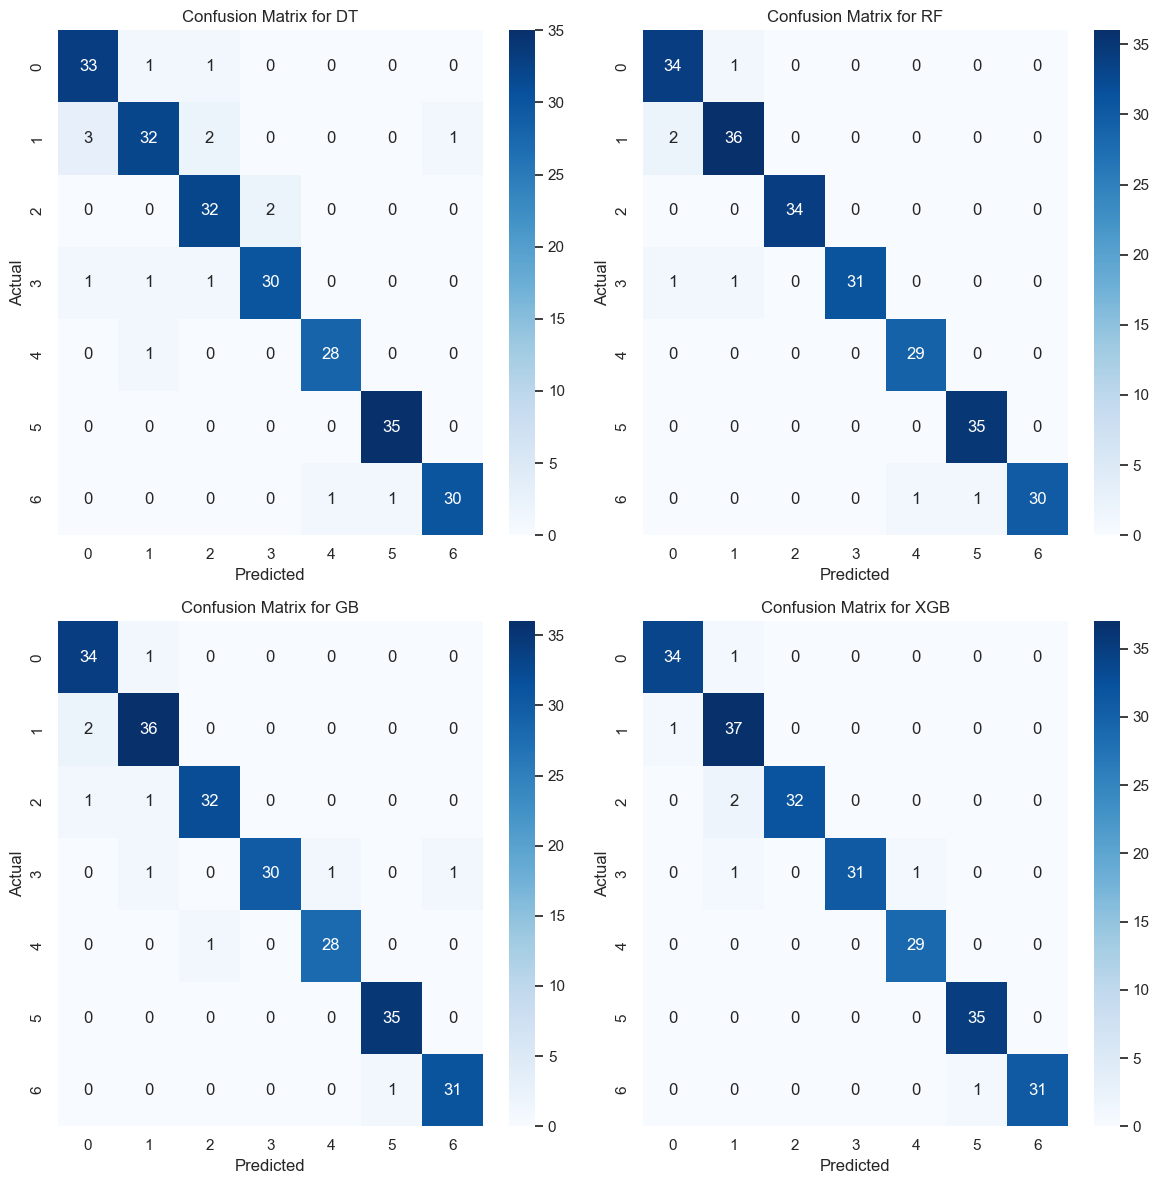

In [138]:
"""Plots confusion matrices for all models in a 2x2 grid."""

def plot_confusion_matrices(best_models, X_test, y_test):    
    
    num_models = len(best_models)
    nrows = (num_models + 1) // 2  # Ensures proper row count for even/odd models
    ncols = 2  # 2 columns for the grid layout
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6 * nrows))
    axes = axes.flatten()  # Flatten in case there's only one row or column
    
    for idx, (model_name, model) in enumerate(best_models.items()):
        # Get predictions on the test set
        y_pred = model.predict(X_test)
        
        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot the confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(f'Confusion Matrix for {model_name}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
    
    # If there are empty subplots (when number of models < total subplots), turn off those axes
    for i in range(len(best_models), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot confusion matrices
plot_confusion_matrices(best_models, X_test, y_test)

### 4.4. ROC Curves

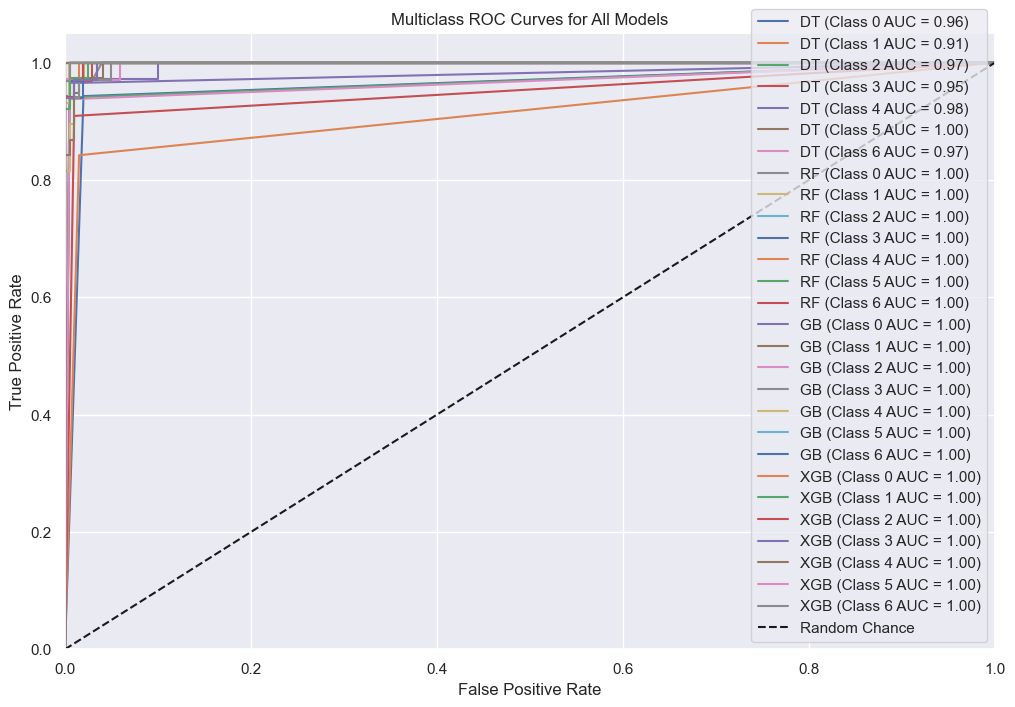

In [141]:
def plot_multiclass_roc_curves(best_models, X_test, y_test, n_classes):
    """Plots ROC curves for multiclass classification using the One-vs-Rest strategy."""
    
    # Binarize the labels for multiclass classification
    y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))
    
    # Create a figure for the ROC curves
    plt.figure(figsize=(12, 8))
    
    for model_name, model in best_models.items():
        if hasattr(model, 'predict_proba'):
            # For models that support predict_proba
            y_score = model.predict_proba(X_test)
        else:
            # For models that support decision_function
            y_score = model.decision_function(X_test)
        
        # Compute ROC curve and AUC for each class
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{model_name} (Class {i} AUC = {roc_auc:.2f})')
    
    # Plot the diagonal line (random chance)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curves for All Models')
    plt.legend(loc='lower right')
    
    plt.show()

# Assuming n_classes is the number of unique profiles in the target variable
n_classes = len(np.unique(y_test))

# Call the function to plot ROC curves
plot_multiclass_roc_curves(best_models, X_test, y_test, n_classes)

### 4.5 LazyClassifier

In [144]:
# Initialize LazyClassifier
clf = LazyClassifier()

# Fit the classifier to the training data
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

 97%|███████████████████████████████████████████████████████████████████████████████▎  | 30/31 [00:01<00:00, 17.67it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 550, number of used features: 33
[LightGBM] [Info] Start training from score -1.915469
[LightGBM] [Info] Start training from score -1.832581
[LightGBM] [Info] Start training from score -1.940470
[LightGBM] [Info] Start training from score -1.966113
[LightGBM] [Info] Start training from score -2.105226
[LightGBM] [Info] Start training from score -1.915469
[LightGBM] [Info] Start training from score -1.966113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 14.87it/s]


In [146]:
# Display the results
print(models)

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
ExtraTreesClassifier               0.98               0.98    None      0.98   
LinearDiscriminantAnalysis         0.98               0.98    None      0.98   
BernoulliNB                        0.97               0.98    None      0.97   
RidgeClassifierCV                  0.97               0.97    None      0.97   
NearestCentroid                    0.97               0.97    None      0.97   
LogisticRegression                 0.97               0.97    None      0.97   
RidgeClassifier                    0.97               0.97    None      0.97   
NuSVC                              0.97               0.97    None      0.97   
SVC                                0.97               0.97    None      0.97   
SGDClassifier                      0.97               0.97    None      0.97   
RandomForestClassifier             0.97 

## 5. Saving Models

In [150]:
# Function to evaluate models and save them with their test accuracy
def evaluate_models(best_models, X_test, y_test):
    for model_name, model in best_models.items():
        y_pred = model.predict(X_test)  # Predict on test data
        accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
        
        # Convert accuracy to an integer percentage (e.g., 0.93 becomes 93)
        accuracy_percentage = int(accuracy * 100)
        
        print(f"{model_name} Test Accuracy: {accuracy_percentage}%")


# Evaluate models
evaluate_models(best_models, X_test, y_test)

DT Test Accuracy: 93%
RF Test Accuracy: 97%
GB Test Accuracy: 95%
XGB Test Accuracy: 97%


In [152]:
def save_models(best_models, scaler, skill_encoder, profile_encoder):
    # Ensure the save directory exists
    save_dir = "../Models/"
    os.makedirs(save_dir, exist_ok=True)
    # Save the model with the formatted accuracy in the filename
    model_filename = os.path.join(save_dir, "best_modelsV2.joblib")
    joblib.dump((best_models, scaler, skill_encoder, profile_encoder ), model_filename)


save_models(best_models, scaler, skill_encoder, profile_encoder)

## 6. Testing

In [155]:
def predict_job_profile(user_input_original):
    for model_name, model in best_models.items():
        user_input = user_input_original.copy()
        
        # Extract Skill 1 and Skill 2 from the input
        skill_1 = user_input[-2]
        skill_2 = user_input[-1]
        
        # Ensure input is transformed appropriately for skills
        user_skills = skill_encoder.transform([[skill_1, skill_2]]).toarray()

        # Combine numerical features and encoded skills
        numerical_features = scaler.transform(np.array(user_input[:-2]).reshape(1, -1))
        user_input_transformed = np.hstack((numerical_features, user_skills))  # Combine arrays

        # Predict using the model
        predicted_profile = model.predict(user_input_transformed)
        predicted_job = profile_encoder.inverse_transform(predicted_profile)
        print(f"Suggested Job Profile by {model_name}: {predicted_job[0]}")

# Example usage: Predict for new user input
user_input = [59,88,84,37,40,40,43,3,7,10,'JavaScript','HTML/CSS']
predict_job_profile(user_input)

Suggested Job Profile by DT: Web Developer
Suggested Job Profile by RF: Web Developer
Suggested Job Profile by GB: Web Developer
Suggested Job Profile by XGB: Web Developer
